In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration (EDA)

In [2]:
location = 'https://raw.githubusercontent.com/niteen11/cuny_lagcc_micro_credential_data_analytics/main/Track%20A/Unit%204%20-%20Machine%20Learning%20and%20Modeling%20Techniques/Dataset/diabetic_data.csv'

In [3]:
df = pd.read_csv(location)

In [4]:
# Replace all missing values '?'s with numpy nan

df.replace('?', np.nan, inplace=True)

In [5]:
# Sample 5 rows

df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
9740,42010278,1375623,Caucasian,Male,[30-40),NaN,3,1,1,3,NaN,InternalMedicine,71,0,6,0,0,0,433,250.02,305,6,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
56435,162081738,41954265,Caucasian,Female,[50-60),NaN,3,1,1,1,BC,Otolaryngology,31,2,37,0,0,1,245,496,401,9,None,None,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
73143,215564088,110327976,Caucasian,Male,[80-90),NaN,1,3,7,6,HM,NaN,67,1,18,0,1,0,428,276,780,9,None,Norm,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
576,4664652,581508,Caucasian,Female,[70-80),NaN,6,25,7,2,NaN,Family/GeneralPractice,69,0,12,0,0,1,434,427,401,9,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
86633,275669484,102879099,Caucasian,Male,[80-90),NaN,1,1,7,3,MC,NaN,61,0,6,4,0,0,599,276,250,9,None,>7,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


In [6]:
# Get some information about the dataset
# Show the number of Non-Null rows
# Show the data type of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Text(0.5, 1.0, 'NaN Data')

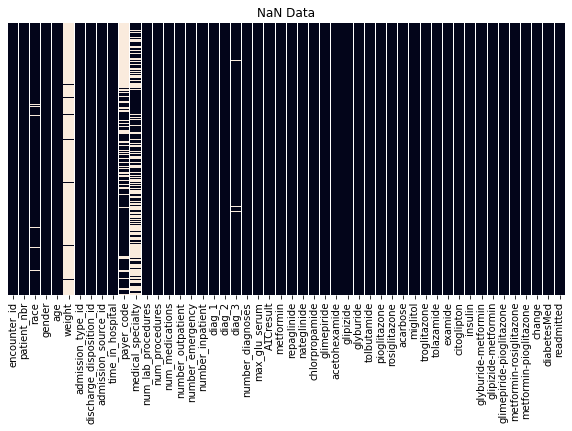

In [7]:
# Visualize the missing data

plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)
plt.title('NaN Data')

Text(0.5, 1.0, 'NaN Data')

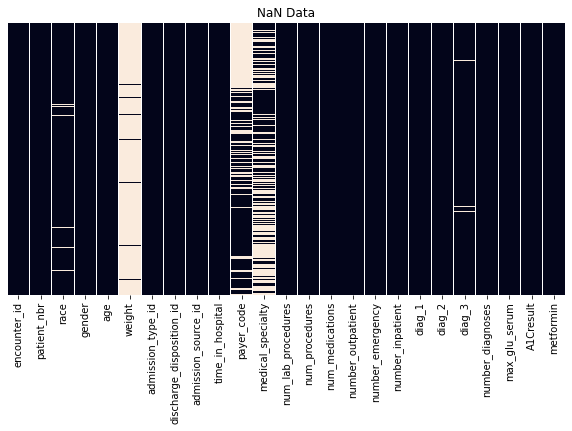

In [8]:
# Visualize the missing data in the first few columns

plt.figure(figsize=(10, 5))
sns.heatmap(df.iloc[:, :-25].isnull(), yticklabels=False, cbar=False)
plt.title('NaN Data')

Text(0.5, 1.0, 'NaN Data')

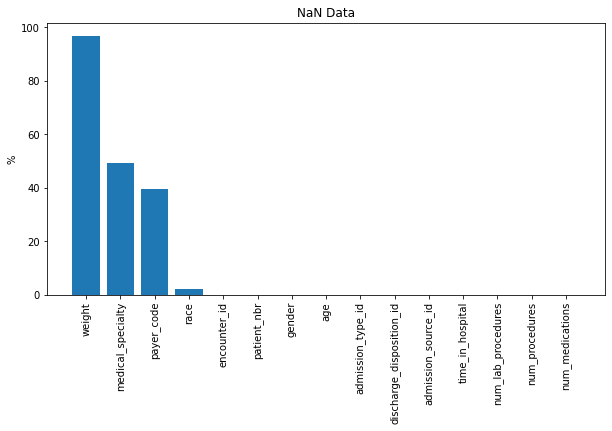

In [9]:
# Visualize the missing data by their sorted percentage

plt.figure(figsize=(10, 5))
missing = pd.DataFrame({'column':df.iloc[:, :-35].columns, 'na_percent':df.iloc[:, :-35].isnull().sum()/len(df)*100})
missing.sort_values('na_percent', ascending=False, inplace=True)
plt.bar(missing['column'], missing['na_percent'])
plt.ylabel('%')
plt.xticks(rotation=90)
plt.title('NaN Data')

In [10]:
# Split 'readmitted' into two classes: readmit within 30 days 1 or not 0

df.loc[:, 'readmitted'] = df.loc[:, 'readmitted'].replace(
    {
        'NO': 0,
       '>30': 0,
       '<30': 1
    }
)

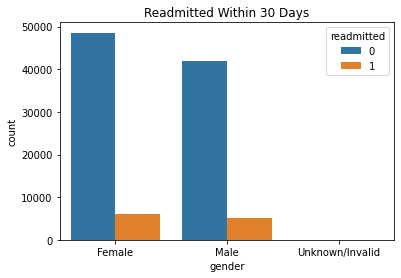

In [11]:
# Visualize readmission rate and gender

sns.countplot(x='gender', data=df, hue='readmitted')
plt.title('Readmitted Within 30 Days')
plt.show()

In [12]:
# Get all gender types in the column

df['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [13]:
# Get the number of 'Unknown/Invalid' rows

len(df.loc[df['gender'] == 'Unknown/Invalid'])

3

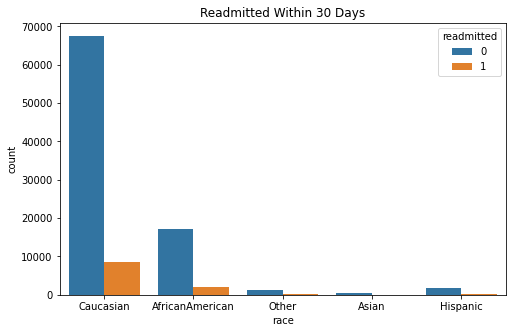

In [14]:
# Visualize readmission rate and race

plt.figure(figsize=(8, 5))
sns.countplot(x='race', data=df, hue='readmitted')
plt.title('Readmitted Within 30 Days')
plt.show()

# Data Preparation (Wrangling/Cleaning, etc.)

### Remove missing values from the dataset

In [15]:
# Drop the columns with over 10% of missing data
df_raw = df.copy()
df.drop(columns=['weight', 'medical_specialty', 'payer_code'], inplace=True)

In [16]:
# Drop rows with any missing value

df.dropna(inplace=True)

In [17]:
# Drop the 3 'Unknown/Invalid' entries in gender

df.drop(df.loc[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

### Drop ID related columns except for 'enounter_id'

In [18]:
ids = ['patient_nbr','admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df.drop(columns=ids, inplace=True)

### Clean up columns 'diag_1', 'diag_2', 'diag_3'

In [19]:
# Map diag codes with their corresponding medical conditions

icd9_table = {
  range(390, 460): 'Circulatory',
  (785,)         : 'Circulatory',
  range(460, 520): 'Respiratory',
  (786,)         : 'Respiratory',
  range(520, 580): 'Digestive',
  (787,)         : 'Digestive',
  (250,)         : 'Diabetes',
  range(800,1000): 'Injury',
  range(710, 740): 'Musculoskeletal',
  range(580, 630): 'Genitourinary',
  (788,)         : 'Genitourinary',
  range(140, 240): 'Neoplasms',
}

In [20]:
# Replace 'E' and 'V' to '-'

cols = ['diag_1', 'diag_2', 'diag_3']
for col in cols:
  df.loc[:, col] = df.loc[:, col].str.replace('E', '-')
  df.loc[:, col] = df.loc[:, col].str.replace('V', '-')

In [21]:
# Convert all the ICD-9 codes to type integer

df.loc[:, cols] = df.loc[:, cols].astype(float).astype(int)

In [22]:
# Define a convert function

def code_to_name(num, table=icd9_table):
  for key, value in table.items():
    if num in key:
      return value
  # return others if not in table    
  return 'Other'


# Convert all the ICD-9 codes to medical conditions

for col in cols:
  df.loc[:, col] = df.loc[:, col].apply(code_to_name)

In [23]:
# Visualize conditions in all diagnoses

diag_dfs = list()

for col in cols:
  d = df.groupby(col)['encounter_id'].nunique().reset_index()
  diag_dfs.append(d)


# Drop 'encounter_id'

df.drop('encounter_id', axis=1, inplace=True)

<BarContainer object of 9 artists>

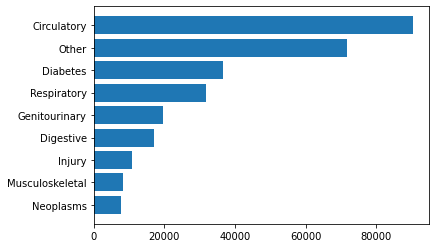

In [24]:
diag_dict = dict()

for frame in diag_dfs:
  for i in range(len(frame)):

    name = frame.iloc[i, 0]
    count = frame.iloc[i, 1]

    if name not in diag_dict:
      diag_dict[name] = count
    else:
      diag_dict[name] += count


names, counts = zip(*diag_dict.items())
counts, names = zip(*sorted(zip(counts, names)))

plt.barh(names, counts)

### Deal with the 'age' column format

In [25]:
df['age'].unique()

array(['[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)',
       '[70-80)', '[80-90)', '[90-100)', '[0-10)'], dtype=object)

In [26]:
# Convert 'age' entries to integers by the upper bound

def get_upper_age(s):
  start = s.index('-') + 1
  end = -1
  return s[start:end]

df.loc[:, 'age'] = df.loc[:, 'age'].apply(get_upper_age)
df.loc[:, 'age'] = df.loc[:, 'age'].astype(int)

Text(0.5, 1.0, 'Age Distribution')

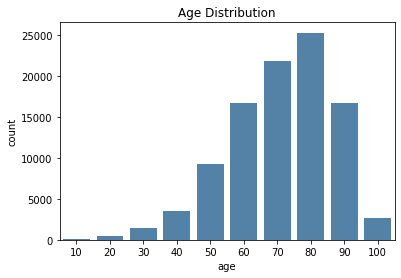

In [27]:
# Visualize age distribution

sns.countplot(x='age', data=df, palette=['SteelBlue'])
plt.title('Age Distribution')

### Format: 'A1Cresult', 'max_glu_serum', 'change', 'diabetesMed'

In [28]:
df['A1Cresult'].unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [29]:
df.loc[:, 'A1Cresult'] = df.loc[:, 'A1Cresult'].replace(
    {'None': 0,
     'Norm': 5,
     '>7'  : 7,
     '>8'  : 8}
)

In [30]:
df['max_glu_serum'].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

In [31]:
df.loc[:, 'max_glu_serum'] = df.loc[:, 'max_glu_serum'].replace(
    {'None': 0,
     'Norm': 100,
     '>300': 300,
     '>200': 200}
)

In [32]:
df['change'].unique()

array(['Ch', 'No'], dtype=object)

In [33]:
df.loc[:, 'change'] = df.loc[:, 'change'].replace(
    {'No': -1,
     'Ch': 1}
)

In [34]:
df['diabetesMed'].unique()

array(['Yes', 'No'], dtype=object)

In [35]:
df.loc[:, 'diabetesMed'] = df.loc[:, 'diabetesMed'].replace(
    {'No' : -1,
     'Yes': 1}
)

### Format the columns from 'metformin' to 'metformin-pioglitazone' related to medications

In [36]:
# Print distinct values in each medication column

def get_meds(frame):
  col_ls = list(frame.columns)
  start = col_ls.index('metformin')
  end = col_ls.index('metformin-pioglitazone') + 1
  return start, end

start, end = get_meds(df)

for col in df.iloc[:, start:end].columns:
  print(df[col].unique())

['No' 'Steady' 'Up' 'Down']
['No' 'Up' 'Steady' 'Down']
['No' 'Steady' 'Down' 'Up']
['No' 'Steady' 'Down' 'Up']
['No' 'Steady' 'Down' 'Up']
['No' 'Steady']
['No' 'Steady' 'Up' 'Down']
['No' 'Steady' 'Up' 'Down']
['No' 'Steady']
['No' 'Steady' 'Up' 'Down']
['No' 'Steady' 'Up' 'Down']
['No' 'Steady' 'Up' 'Down']
['No' 'Steady' 'Down' 'Up']
['No' 'Steady']
['No' 'Steady' 'Up']
['No']
['No']
['Up' 'No' 'Steady' 'Down']
['No' 'Steady' 'Down' 'Up']
['No' 'Steady']
['No' 'Steady']
['No']
['No' 'Steady']


In [37]:
# Drop the columns with uniform rows

start, end = get_meds(df)

for col in df.iloc[:, start:end].columns:
  if len(df[col].unique()) == 1:
    df.drop(columns=col, inplace=True)

In [38]:
# Format remaining medication columns (21 to 40)

start, end = get_meds(df)

for col in df.iloc[:, start:end].columns:
  df.loc[:, col] = df.loc[:, col].replace(
    {'No'    : -20,
     'Down'  : -10,
     'Steady': 0,
     'Up'    : 10}
  )

### Encode remaining dtype 'object' columns

In [39]:
df.select_dtypes('object').columns

Index(['race', 'gender', 'diag_1', 'diag_2', 'diag_3'], dtype='object')

In [40]:
# Convert categorical variable into dummy/indicator variables

obj_cols = df.select_dtypes('object').columns

for col in obj_cols:
  df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col])], axis=1)

# Build and Evaluate Models

In [41]:
try:
    df.head()
    print('df exists')
    
except NameError:
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = pd.read_csv('cleaned_diabetes.csv')
    print('df is loaded')
    
    
    
# Create X (all columns except target)
X = df.drop('readmitted', axis=1)

# Create y (only the target column)
y = df.loc[:, 'readmitted']

# Import train_test_split from sklearn's model_selection module
from sklearn.model_selection import train_test_split

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

df exists


### Logistic Regression

In [42]:
# View the different shapes of the training and test datasets

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73539, 67), (24513, 67), (73539,), (24513,))

In [43]:
# Import LogisticRegression from sklearn's linear_model
from sklearn.linear_model import LogisticRegression

# Create an instance of LogisticRegression as log
log = LogisticRegression(solver='liblinear',random_state=88)

In [44]:
# Fit the LogisticRegression to the training data

log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=88, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# Use the fitted model to make predictions on the test data and
# store the predictions to a variable called predict

predict = log.predict(X_test)

In [46]:
log.score(X_test, y_test)

0.8861828417574348

In [47]:
# Import confusion_matrix from sklearn's metrics module
from sklearn.metrics import confusion_matrix

# # Fit the test labels and predictions into confusion_matrix and
# print the matrix
print(confusion_matrix(y_test, predict))

[[21683    55]
 [ 2735    40]]


In [48]:
# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=True,
                     cmap='GnBu')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

Text(0.5, 1.0, 'Logistic Regression \n Accuracy 0.89\n')

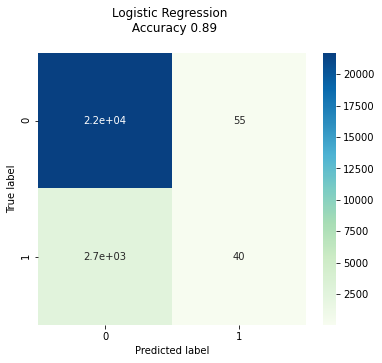

In [49]:
# Call plot_conf_mat with the test labels and predictions
plot_conf_mat(y_test, predict)


# Give the matrix a title
score = round(log.score(X_test, y_test), 2)
plt.title(f'Logistic Regression \n Accuracy {score}\n')

In [50]:
# Import classification_report from sklearn's metrics module
from sklearn.metrics import classification_report

# Fit the test labels and predictions into classification_report and
# print the report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     21738
           1       0.42      0.01      0.03      2775

    accuracy                           0.89     24513
   macro avg       0.65      0.51      0.48     24513
weighted avg       0.84      0.89      0.84     24513



**Precision** - Indicates the proportion of positive identifications (model predicted class 1) which were actually correct. A model which produces no false positives has a precision of 1.0.

**Recall** - Indicates the proportion of actual positives which were correctly classified. A model which produces no false negatives has a recall of 1.0.

**/F1 score** - A combination of precision and recall. A perfect model achieves an F1 score of 1.0.

**Support** - The number of samples each metric was calculated on.

**Accuracy** - The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0.

**Macro avg** - Short for macro average, the average precision, recall and F1 score between classes. Macro avg doesn’t class imbalance into effort, so if you do have class imbalances, pay attention to this metric.

**Weighted avg** - Short for weighted average, the weighted average precision, recall and F1 score between classes. Weighted means each metric is calculated with respect to how many samples there are in each class. This metric will favour the majority class (e.g. will give a high value when one class out performs another due to having more samples).

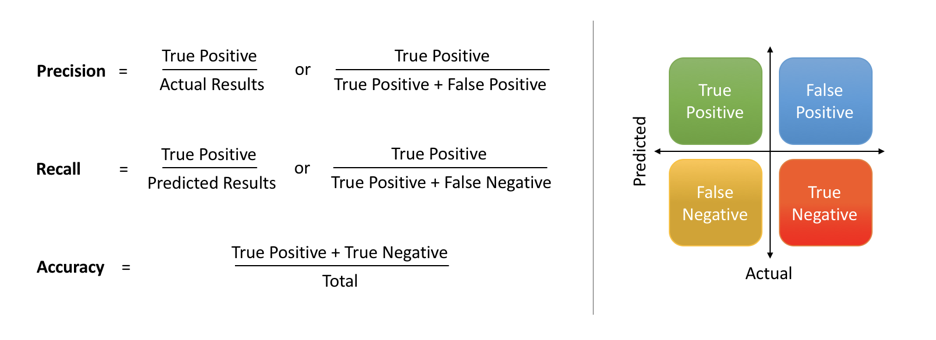

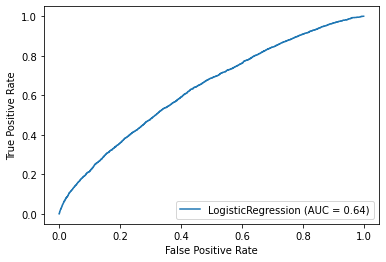

In [51]:
# Import plot_roc_curve from sklearn's metrics module
from sklearn.metrics import plot_roc_curve

# Plot a ROC curve using our current model using plot_roc_curve
plot_roc_curve(log, X_test, y_test)

### K-Nearest Neighbors

#### Standardize data for KNN algorithm

In [53]:
# Import StandardScaler from sklearn's preprocessing module
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler as scaler
scaler = StandardScaler()

# Fit the StandardScaler to the features
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
# Import KNeighborsClassifier frrom sklearn's neighbors module
from sklearn.neighbors import KNeighborsClassifier

[0.18728837759556155, 0.1210378166687064, 0.11406192632480724, 0.11328682739770735, 0.11304205931546527]


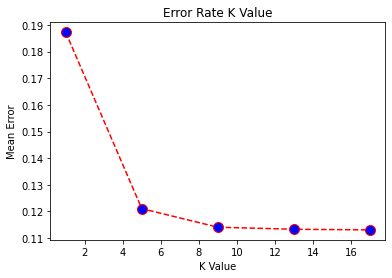

In [56]:
# # Calculate error for K values between 1 and 19 step 4
error = []

for i in range(1, 20, 4):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

print(error)
    
# Visulaize the relationship between error rate and k value
# plt.figure(figsize=(12, 6))
plt.plot(range(1, 20, 4), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [57]:

# Create an instance of KNeighborsClassifier as knc
knc = KNeighborsClassifier(n_neighbors=13)

In [58]:
# Fit the KNeighborsClassifier to the training data

knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [59]:
# Use the fitted model to make predictions on the test data and
# store the predictions to a variable called pred

pred = knc.predict(X_test)

In [64]:
knc_score = knc.score(X_test, y_test)
print(knc_score)

0.8867131726022927


In [61]:
# # Fit the test labels and predictions into confusion_matrix and
# print the matrix

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred))

[[21708    30]
 [ 2747    28]]


In [62]:
# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=True,
                     cmap='GnBu')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

Text(0.5, 1.0, 'K-Neighbors \n Accuracy 0.89\n')

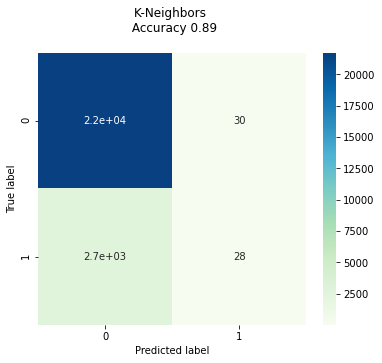

In [65]:
# Call plot_conf_mat with the test labels and predictions
plot_conf_mat(y_test, pred)


# Give the matrix a title
plt.title(f'K-Neighbors \n Accuracy {knc_score:.2f}\n')

In [66]:
# Import classification_report from sklearn's metrics module
from sklearn.metrics import classification_report

# Fit the test labels and predictions into classification_report and
# print the report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     21738
           1       0.48      0.01      0.02      2775

    accuracy                           0.89     24513
   macro avg       0.69      0.50      0.48     24513
weighted avg       0.84      0.89      0.84     24513



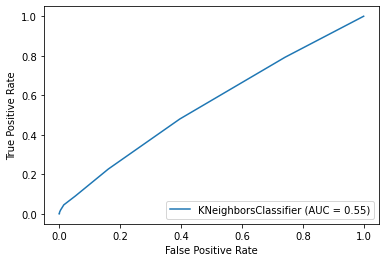

In [67]:
# Import plot_roc_curve from sklearn's metrics module
from sklearn.metrics import plot_roc_curve

# Plot a ROC curve using our current model using plot_roc_curve
plot_roc_curve(knc, X_test, y_test)

### Random Forest

In [68]:
# Import RandomForestClassifier from sklearn's ensemble module
from sklearn.ensemble import RandomForestClassifier

# Create an instance of RandomForestClassifier as rfc
rfc = RandomForestClassifier(max_depth=28, criterion = "entropy", 
                             min_samples_split=10, random_state=88)

In [69]:
# Fit the RandomForestClassifier to the training data

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=28, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [70]:
# Use the fitted model to make predictions on the test data and
# store the predictions to a variable called rf_pred

rf_pred = rfc.predict(X_test)

In [71]:
# # Fit the test labels and predictions into confusion_matrix and
# print the matrix

print(confusion_matrix(y_test, rf_pred))

[[21726    12]
 [ 2762    13]]


In [72]:
# rfc_score = rfc.score(X_test, y_test)
# print(rfc_score)

0.8868355566434137


Text(0.5, 1.0, 'Random Forest\n')

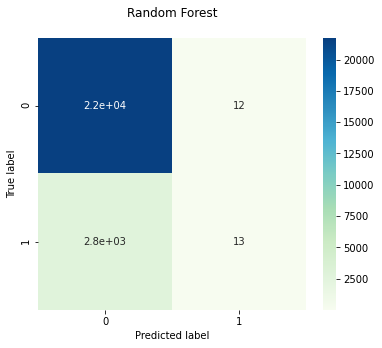

In [73]:
# Call plot_conf_mat with the test labels and predictions
plot_conf_mat(y_test, rf_pred)


# Give the matrix a title
plt.title('Random Forest\n')

In [88]:
# Import classification_report from sklearn's metrics module
from sklearn.metrics import classification_report

# Fit the test labels and predictions into classification_report and
# print the report

print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     21738
           1       0.52      0.00      0.01      2775

    accuracy                           0.89     24513
   macro avg       0.70      0.50      0.47     24513
weighted avg       0.85      0.89      0.83     24513



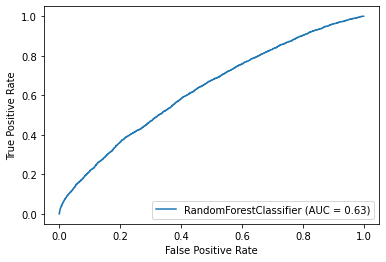

In [75]:
# Import plot_roc_curve from sklearn's metrics module
from sklearn.metrics import plot_roc_curve

# Plot a ROC curve using our current model using plot_roc_curve
plot_roc_curve(rfc, X_test, y_test)

### Compare Models

In [3]:
# Create a data frame with the models perfoamnce metrics scores

models_scores_table = pd.DataFrame({'Logistic Regression':[0.89,
                                                           0.84,
                                                           0.89,
                                                           0.84,
                                                           0.64],

                                    'K-Nearest Neighbors':[0.89,
                                                           0.84,
                                                           0.89,
                                                           0.84,
                                                           0.55],

                                          'Random Forest':[0.89,
                                                           0.85,
                                                           0.89,
                                                           0.83,
                                                           0.63],},
                                    
                                   index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
                                   )
    

# Add 'Best Score' column
models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

In [4]:
models_scores_table

,Logistic Regression,K-Nearest Neighbors,Random Forest,Best Score
Accuracy,0.89,0.89,0.89,Logistic Regression
Precision,0.84,0.84,0.85,Random Forest
Recall,0.89,0.89,0.89,Logistic Regression
F1 Score,0.84,0.84,0.83,Logistic Regression
AUC,0.64,0.55,0.63,Logistic Regression


# Conclusion/Observation

According to the results from the table above, all three models have similar results.

The LogisticRegression is the most computational efficient approach.

The KNeighborsClassifier is the least computational efficient approach.

The KNeighborsClassifier has the lowest AUC score, slightly better than random guessing.

---



All the models seem to tilt toward negative with very high false negative. The relatively small (8x less) positive examples in the dataset may contribute to this. The ratio of negatives and positives is about 9 : 1  in this dataset.